In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import nltk
#nltk.download('stopwords')
from nltk.corpus import stopwords

from colorama import Fore, Style

%matplotlib inline

In [2]:
df = pd.read_csv('datas/critiques_star_wars_7.csv')

# Partie 1 : Quelques statistiques sur les donn√©es

In [3]:
df.head()

auteur note                 date  \
0     Johan Gendry  5,0  2020-04-11 00:00:00   
1        Damianous  3,0  2020-04-01 00:00:00   
2  Lilian Bernabeu  1,5  2020-03-30 00:00:00   
3         FaulKeuR  3,5  2020-03-22 00:00:00   
4        Lin Guini  1,0  2020-03-20 00:00:00   

                                            critique  
0  \n                      En 3 jours je me suis ...  
1  \n                      √áa commence plut√¥t bie...  
2  \n                      Bon je vais faire en s...  
3  \n                      J. J. Abrams a eu la l...  
4  \n                      Pire id√©e de suite. G√¢...

In [4]:
df.describe() # quelques informations sur les features

auteur  note                 date  \
count          4595  4595                 4595   
unique         4259    10                  557   
top     Un visiteur   0,5  2015-12-26 00:00:00   
freq             99   598                  279   

                                                 critique  
count                                                4595  
unique                                               4591  
top     \n                      Un septi√®me opus spect...  
freq                                                    2

In [5]:
# conversion des notes en entier
df['note'] = df['note'].apply(lambda x: x.replace(',', '.')).apply(lambda x: float(x))

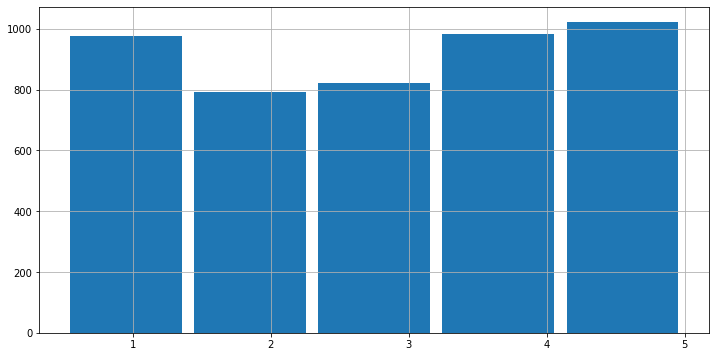

In [6]:
df['note'].hist(bins=5, figsize=(12,6), rwidth=0.9)

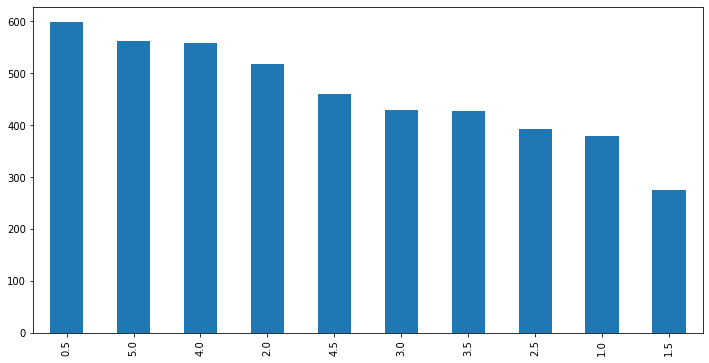

In [7]:
# distribution des notes
df['note'].value_counts().plot(kind='bar', figsize=(12,6))

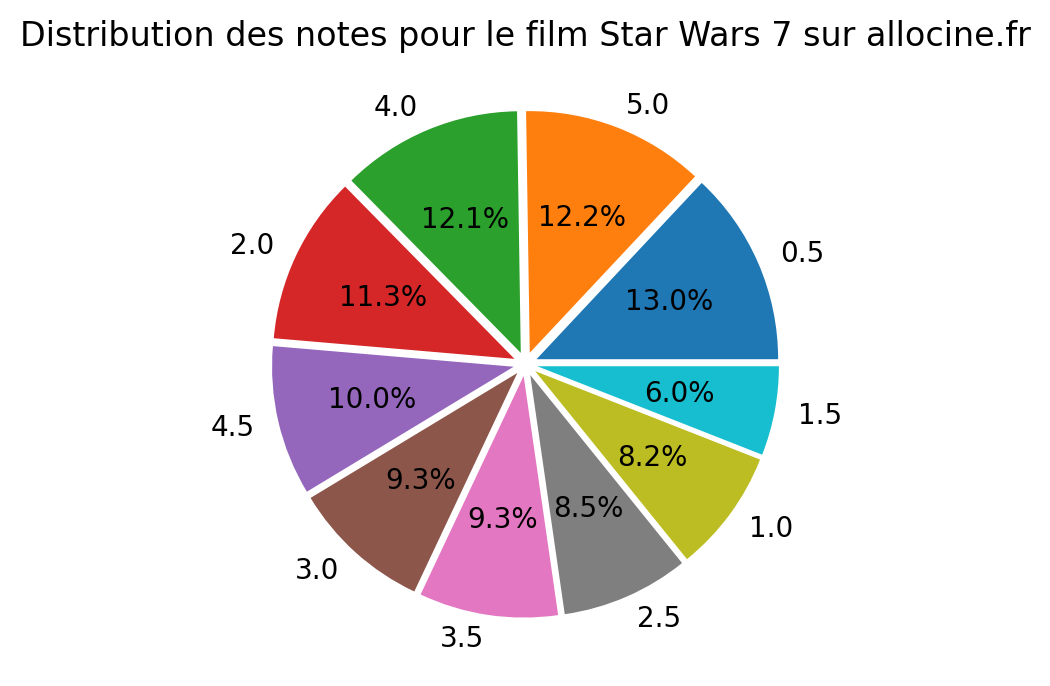

In [8]:
# Pie charts
notes_cat = list(df['note'].value_counts().index)
notes_distrib = df['note'].value_counts().values

plt.figure(figsize=(4,4), dpi=200)
plt.title('Distribution des notes pour le film Star Wars 7 sur allocine.fr')
plt.pie(notes_distrib, labels=notes_cat, explode=[float(0.05) for i in range(10)], autopct='%1.1f%%')
plt.show()

In [9]:
print("Moyenne des notes de star wars 7 (pour les personnes qui ont post√©es) :", round(df['note'].mean(), 1))
# le site indique 3.5/5 pour l'ensemble des notes

Moyenne des notes de star wars 7 (pour les personnes qui ont post√©es) : 2.8


In [10]:
# conversion de la date en objet datetime
df['date'] = pd.to_datetime(df['date'])

In [11]:
# time series
df.set_index('date', inplace=True)

In [12]:
# du plus ancien commentaire au plus r√©cent
df.sort_index(inplace=True)

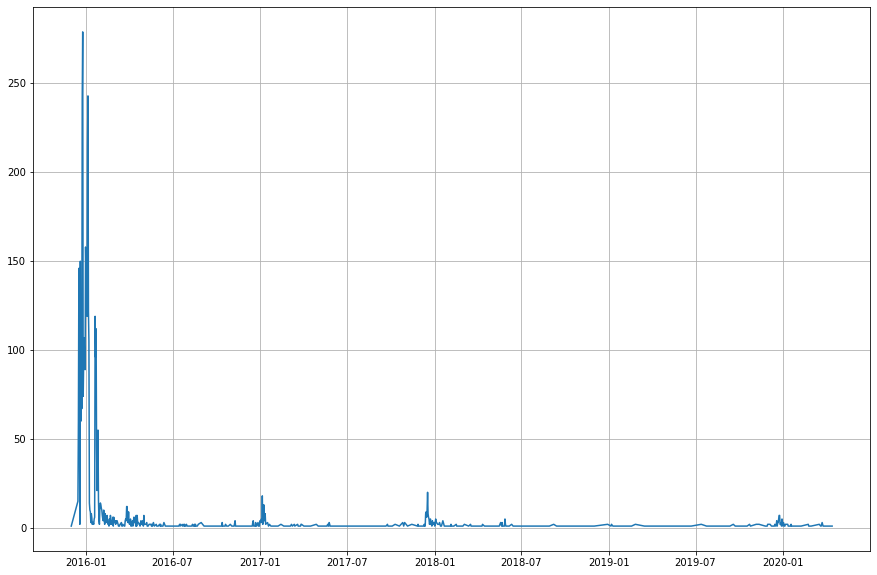

In [13]:
df.groupby(df.index.date).count()['note'].plot(figsize=(15,10), grid=True)

On remarque que l'essentiel des critiques se concentrent lors de la sortie du film. On observe √©galement un pic d'activit√© lors de la sortie des deux films suivants Star Wars 8 (d√©cembre 2017) et Star Wars 9 (d√©cembre 2019) ainsi qu'au moment de la sortie des films d√©riv√©s de l'univers star wars (Rogue One et Solo, respectivement en d√©cembre 2016 et mai 2018).

In [14]:
d = df.groupby(df.index.date).count()['note'].idxmax().strftime('%A, %d/%m/%Y')
print('Jour du plus grand nombre de commentaires post√©s :', d)
print(df.groupby(df.index.date).count()['note'].max(), 'commentaires')

Jour du plus grand nombre de commentaires post√©s : Saturday, 26/12/2015
279 commentaires


In [15]:
# 10 visiteurs qui ont post√© le plus de critiques (noms g√©n√©riques)
df['auteur'].value_counts().head(10)

Un visiteur     99
Thomas C.        6
Alexandre D.     5
Romain M.        5
Nicolas B.       5
Nicolas T.       4
Romain S.        4
Olivier M.       4
Alexandre L.     4
Alex C.          4
Name: auteur, dtype: int64

# Partie 2 : Natural Language Processing

## Pr√©paration des donn√©es

In [16]:
# affichage d'une critique
random_critique = df['critique'][45]
print(random_critique)


                      Le "vrai" ADN de la saga initiale, avec les moyens d'aujourd'hui (voir de demain). Un casting au top. indispensable.
        
            


In [17]:
def strip_text(text):
    return text.lstrip('\n                      ').rstrip('\n        \n            ')

In [18]:
df['critique'] = df['critique'].apply(strip_text)

In [19]:
print(df['critique'][45])

Le "vrai" ADN de la saga initiale, avec les moyens d'aujourd'hui (voir de demain). Un casting au top. indispensable.


Cr√©ation de la **feature** `sentiment` bas√©e sur la note :
- 0 √©quivaut √† un sentiment positif
- 1 √† un sentiment n√©gatif

In [20]:
def create_sentiment(note):
    
    # sentiment n√©gatif == 1
    if note in [0.5,1,1.5,2]:
        return 1
    
    # sentiment positif == 0
    else:
        return 0

In [21]:
df['sentiment'] = df['note'].apply(create_sentiment)

In [22]:
# on remet l'index num√©rique
df.reset_index(inplace=True)

In [23]:
df.head()

date           auteur  note  \
0 2015-12-02      Un visiteur   0.5   
1 2015-12-16      JeanS√©√©√©√©√©√©   3.5   
2 2015-12-16  Rainfall_Shadow   5.0   
3 2015-12-16         Damien D   1.5   
4 2015-12-16      pastorey B.   0.5   

                                            critique  sentiment  
0  Un nouvel opus pas touchant et plein de maladr...          1  
1  Tous les nouveaux personnages sont excellents ...          0  
2  Fermez les yeux, r√©veillez vous 30 ans apr√®s l...          0  
3  Ce film est tous simplement un film d action. ...          1  
4  apr√©s la grosse banane de la menace fantome , ...          1

In [24]:
# on import les stopwords de NLTK
french_stopwords = set(stopwords.words('french'))

In [25]:

vectorizer = CountVectorizer(stop_words=french_stopwords)

In [26]:
all_features = vectorizer.fit_transform(df['critique'])

In [27]:
all_features.shape

(4595, 26800)

In [28]:
X_train, X_test, y_train, y_test = train_test_split(all_features, df['sentiment'], test_size=0.2, random_state=42)

In [29]:
X_train.shape

(3676, 26800)

In [30]:
X_test.shape

(919, 26800)

## Classification avec Naive Bayes

In [31]:
classifier = MultinomialNB()

In [32]:
classifier.fit(X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [33]:
predictions = classifier.predict(X_test)

In [34]:
print(classification_report(y_test, predictions))
print(confusion_matrix(y_test, predictions))

              precision    recall  f1-score   support

           0       0.85      0.90      0.87       577
           1       0.81      0.73      0.77       342

    accuracy                           0.84       919
   macro avg       0.83      0.81      0.82       919
weighted avg       0.83      0.84      0.83       919

[[517  60]
 [ 91 251]]


In [35]:
nb_correct = (y_test == predictions).sum()
print('Nombre de bonnes pr√©dictions', nb_correct)

Nombre de bonnes pr√©dictions 768


In [36]:
nb_incorrect = y_test.size - nb_correct
print('Nombre de mauvaises pr√©dictions', nb_incorrect)

Nombre de mauvaises pr√©dictions 151


In [37]:
fraction_wrong = nb_incorrect / (y_test.size)
print(f'La pr√©cision du mod√®le est de {1-fraction_wrong:.2%}')

La pr√©cision du mod√®le est de 83.57%


## Test avec des commentaires fictifs (*sentiment analysis*)

In [38]:
# on g√©n√®re des commentaires fictifs
commentaires = ["Ce film est nul ! C'est le plus mauvais film que j'ai vu depuis longtemps. Aucun int√©r√™t. Une sombre daube",
               "Ce film est g√©nial, c'est le meilleur Star Wars. Super film, j'ai ador√© !",
              "C'est un tr√®s tr√®s bon star wars, j'ai beaucoup aim√© ce film, il est g√©nial, les personnages sont excellents.",
              "C'est le pire film de l'ann√©e, une vraie bouse, m√©diocre. Un film d√©bile, j'ai d√©test√© !"]

In [39]:
# on vectorise les commentaires pour la pr√©diction
doc_term_matrix = vectorizer.transform(commentaires)

Ici, une boucle nous permettra des tester nos commentaires. Les critiques positives sont affich√©es en `vert`, les critiques n√©gatives en `rouge`.

In [40]:
for result, commentaire in zip(classifier.predict(doc_term_matrix), commentaires):
    if result == 1:
        commentaire = Fore.RED + '[-] ' + commentaire + Style.RESET_ALL
    else:
        commentaire = Fore.GREEN + '[+] ' + commentaire + Style.RESET_ALL
    print(commentaire)

[-] Ce film est nul ! C'est le plus mauvais film que j'ai vu depuis longtemps. Aucun int√©r√™t. Une sombre daube
[+] Ce film est g√©nial, c'est le meilleur Star Wars. Super film, j'ai ador√© !
[+] C'est un tr√®s tr√®s bon star wars, j'ai beaucoup aim√© ce film, il est g√©nial, les personnages sont excellents.
[-] C'est le pire film de l'ann√©e, une vraie bouse, m√©diocre. Un film d√©bile, j'ai d√©test√© !


## Examen des critiques mal class√©es

In [41]:
nbr_crit = y_test.size
print('Nombre de critiques dans notre jeu d\'entra√Ænement :', nbr_crit)

Nombre de critiques dans notre jeu d'entra√Ænement : 919


In [42]:
nbr_crit_pos = y_test[y_test == 0].size
print(f'Nombre de critiques positives dans notre jeu d\'entra√Ænement:\
\t{nbr_crit_pos}\t{nbr_crit_pos/nbr_crit:.0%}')

Nombre de critiques positives dans notre jeu d'entra√Ænement:	577	63%


In [43]:
nbr_crit_neg = y_test.sum()
print(f'Nombre de critiques n√©gatives dans notre jeu d\'entra√Ænement:\
\t{nbr_crit_neg}\t{nbr_crit_neg/nbr_crit:.0%}')

Nombre de critiques n√©gatives dans notre jeu d'entra√Ænement:	342	37%


### Examen des critiques n√©gatives class√©es comme postives

In [44]:
nbr_crit_neg_mal_clas = df.loc[y_test[(y_test == 1) & (predictions == 0)].index].sum()['sentiment']
print(f"{nbr_crit_neg_mal_clas} critiques n√©gatives sont mal class√©es \
({nbr_crit_neg_mal_clas/nbr_crit_neg:.2%})")

91 critiques n√©gatives sont mal class√©es (26.61%)


On peut voir en d√©tail quelles sont les critiques mal class√©es en fonction de leur note originelle

In [45]:
df.loc[y_test[(y_test == 1) & (predictions == 0)].index]['note'].value_counts()

2.0    48
1.0    18
1.5    16
0.5     9
Name: note, dtype: int64

Plus de la moiti√© des commentaires n√©gatifs mal class√©s sont les commentaires ayant recueillis la note de **2/5**. C'est assez logique, ce sont les moins p√©joratifs donc les plus difficiles √† classer, que ce soit pour un humain ou un algorithme.

In [46]:
df.loc[y_test[(y_test == 1) & (predictions == 0)].index]['note'].value_counts() / y_test.sum()

2.0    0.140351
1.0    0.052632
1.5    0.046784
0.5    0.026316
Name: note, dtype: float64

On remarque √©galement que **14%** des critiques ayant eu la note de **2/5** sont mal class√©es. En revanche seulement **2.6%** des critiques les plus n√©gatives **0.5/5** sont consid√©r√©es comme positives.

In [47]:
# on r√©cup√®re l'index des 9 critiques n√©gatives not√©es 0.5/5 class√©es comme positives
false_negatives = df.loc[y_test[(y_test == 1) & (predictions == 0)].index]
index_false_neg = false_negatives[false_negatives['note'] == 0.5].index

In [48]:
for index in index_false_neg:
    print(index, ':', df.iloc[index]['critique'])
    print('*' * 100)

3052 : Ni puriste, ni indiff√©rent, j'ai trouv√© ce nouvel opus g√¢ch√© par son sc√©nario !
La r√©alisation elle n'est pas trop mal, l'univers est respect√©.
Je n'ai aim√© pratiquement aucun jeux d'acteur sauf certains qui √©taient d√©j√† pr√©sent dans les anciens. Le pire de tous reste l'interpr√®te de Kylo Ren. Quand √† Rey et Finn, ce n'est pas qu'ils sont mauvais mais ils n'ont pas r√©ussi √† me toucher. Oscar Isaac rel√®ve un peu le niveau.
Ce que je n'ai pas aim√© non plus est la non cr√©dibilit√© de certaines sc√®nes et surtout la relation d'un certain personnage avec la force (mais je vous laisse d√©couvrir par vous m√™me).
Conclusion : l'histoire est vraiment ce qui m'a fait le plus detester ce film suivi de l'erreur de casting.
****************************************************************************************************
3728 : Pour r√©sumer,

Si vous n'avais JAMAIS vu Star Wars, vous allez aimer ce film.
Si vous avez entre 3 et 13 ans, vous allez aimer ce film.
Si vous

On remarque que certaines critiques, notamment la **4568** sont difficiles √† classer car leurs auteurs utlisent l'ironie et donc des termes m√©lioratifs pour exprimer un sentiment n√©gatif. L'algorithme Naive Bayes classe les critiques en fonction de la pr√©sence de certains termes : si ces termes sont davatange pr√©sents dans les critiques positives, alors il en d√©duira que la critique est positive. Une utilisation de termes m√©lioratifs fera que la critique sera statistiquement consid√©r√©e comme √©tant positive.

### Examen des critiques positives class√©es comme n√©gatives

In [49]:
nbr_crit_pos_mal_clas = df.loc[y_test[(y_test == 0) & (predictions == 1)]].shape[0]
print(f"{nbr_crit_pos_mal_clas} critiques positives sur {nbr_crit_pos} sont mal class√©es \
({nbr_crit_pos_mal_clas/nbr_crit_pos:.2%})")

60 critiques positives sur 577 sont mal class√©es (10.40%)


In [50]:
df.loc[y_test[(y_test == 0) & (predictions == 1)].index]['note'].value_counts()

2.5    30
3.0    13
3.5    10
5.0     3
4.5     2
4.0     2
Name: note, dtype: int64

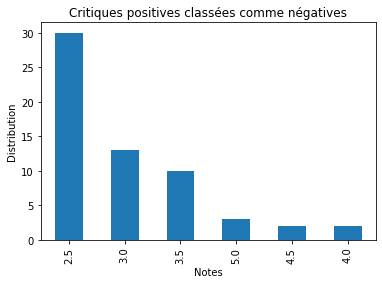

In [51]:
# on peut localiser les critiques et afficher un histogramme
plt.title('Critiques positives class√©es comme n√©gatives')
plt.xlabel('Notes')
plt.ylabel('Distribution')
df.loc[y_test[(y_test == 0) & (predictions == 1)].index]['note'].value_counts().plot(kind='bar')

In [52]:
df.loc[y_test[(y_test == 0) & (predictions == 1)].index]['note'].value_counts() / nbr_crit_pos_mal_clas

2.5    0.500000
3.0    0.216667
3.5    0.166667
5.0    0.050000
4.5    0.033333
4.0    0.033333
Name: note, dtype: float64

De la m√™me mani√®re, on observe que les critiques positives les moins bien class√©es sont celles ayant obtenues la note de **2.5/5**. Ce sont les "moins bonnes" des critiques positives et donc celles les plus susceptibles d'utiliser des termes p√©joratifs.

In [53]:
# on affiche les 3 critiques 5/5 mal class√©es

false_positives = df.loc[y_test[(y_test == 0) & (predictions == 1)].index]
index_false_pos = false_positives[false_positives['note'] == 5].index

In [54]:
for index in index_false_pos:
    print(index, ':', df.loc[index]['critique'])
    print('*' * 100)

3807 : Bonjour je voudrais juste dire √† ceux qui mette des critique aussi horrible a mettre m√™me une √©toile il dise n'importe quoi il connaisse rien sur star wars il sont rien comprit vous il ƒèisent que c la m√™me histoire que dans le 4/5/6 oui je suis d'accord avec sa mais pas compl√®tement par ce que moi je dis que c la suite de l'histoire c pas de la pareille c juste la suite de l'histoire moi je trouve qu'il √©tais cool de film il √©tait superbes et en plus √† ce qui dise que c'√©tait nul l'√©pisode 8 sera mieux par ce que j'ai vue qu'il vont changer l'histoire sa va pas √™tre pareille comme vous dites donc aller le regarder il sera mieux je vous le promet . Moi j'ai ador√©e se film touts √©tait bien fait je suis encore une fois fan de cette √©pisode 7 touts et bien jou√© je met les 5etoiles je donnerais 100/100 pour se film j'adore les personnages qui joue dedant et touts .merci d'avoir lu ma critiques
***************************************************************************

On remarque une chose int√©ressante ici c'est que l'algorithme a correctement class√©e une critique positive comme √©tant n√©gative. En effet la critique **4593** est n√©gative mais a √©t√© not√©e positivement par son auteur (s√ªrement une erreur de l'auteur au moment de la saisie de la note). Quant aux deux autres critiques, il s'agit de critiques dans lesquelles leurs auteurs d√©fendent leur point de vue et s'en prennent aux *haters* et donc utilisent des termes p√©joratifs pour d√©signer ces derniers. Les termes p√©joratifs classent donc la critique dans la cat√©gorie n√©gative.

In [55]:
# par s√©curit√©, on v√©rifie que la critique 4593 est bien not√©e 5/5
df.iloc[4593]['note']

5.0

## Classification avec SVM

In [56]:
from sklearn.svm import SVC

In [57]:
svc = SVC(kernel='linear', C=5)

In [58]:
svc.fit(X_train, y_train)

SVC(C=5, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [59]:
svc_predictions = svc.predict(X_test)

In [60]:
print(classification_report(y_test, svc_predictions))
print(confusion_matrix(y_test, svc_predictions))

              precision    recall  f1-score   support

           0       0.83      0.83      0.83       577
           1       0.71      0.71      0.71       342

    accuracy                           0.78       919
   macro avg       0.77      0.77      0.77       919
weighted avg       0.78      0.78      0.78       919

[[478  99]
 [100 242]]


## Avec GridSearchCV

In [61]:
from sklearn.model_selection import GridSearchCV

In [62]:
parameters = {'C':[i for i in range(1, 20)]}

In [63]:
parameters

{'C': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]}

In [64]:
clf = GridSearchCV(svc, parameters, cv=2)

In [65]:
clf.fit(X_train, y_train)

GridSearchCV(cv=2, error_score=nan,
             estimator=SVC(C=5, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='linear', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14,
                               15, 16, 17, 18, 19]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [66]:
print(clf.best_params_) # on relance svc avec C=1 en param√®tre

{'C': 1}


In [67]:
svc = SVC(kernel='linear', C=1)
svc.fit(X_train, y_train)
svc_predictions = svc.predict(X_test)
print(classification_report(y_test, svc_predictions))
print(confusion_matrix(y_test, svc_predictions))

              precision    recall  f1-score   support

           0       0.83      0.83      0.83       577
           1       0.71      0.71      0.71       342

    accuracy                           0.78       919
   macro avg       0.77      0.77      0.77       919
weighted avg       0.78      0.78      0.78       919

[[477 100]
 [100 242]]


Avec un meilleur `param√®tre` C, on obtient un plus mauvais r√©sultat (1 bonne pr√©diction en moins).